In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

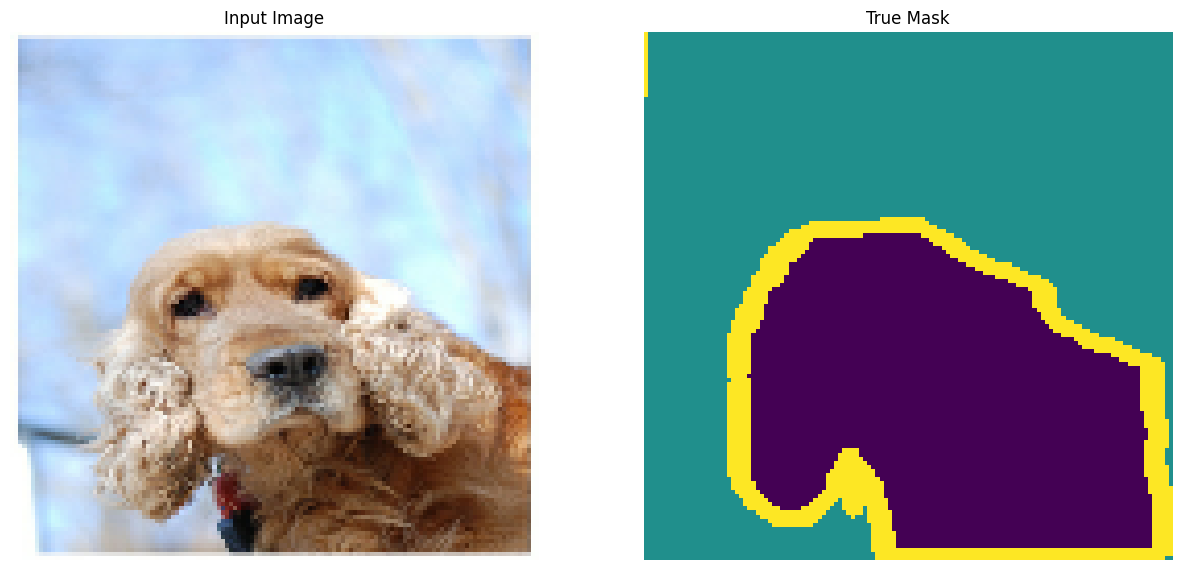

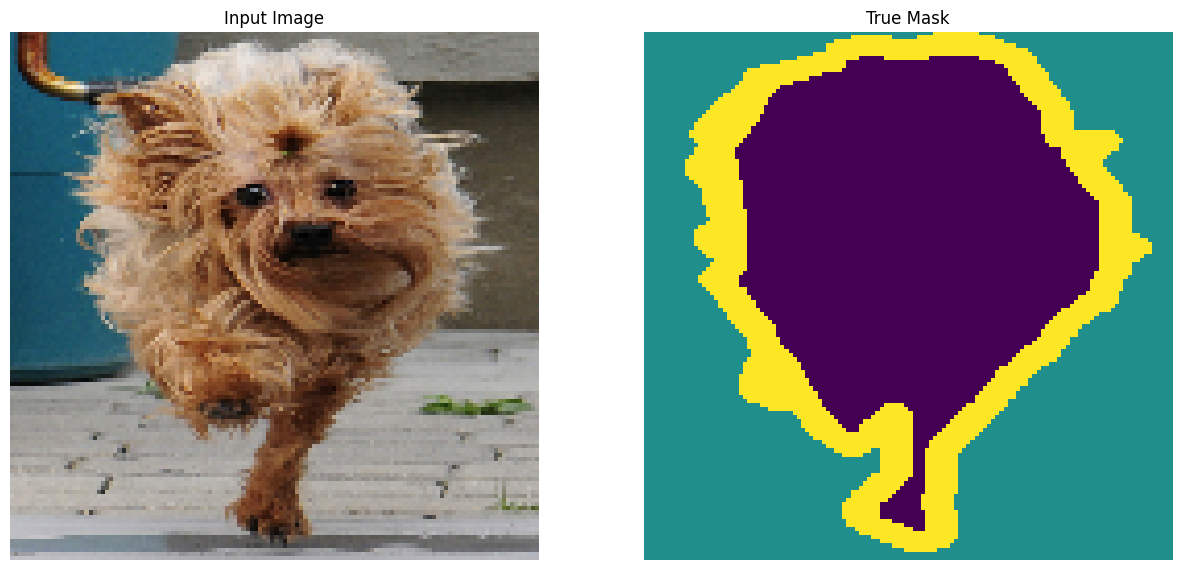

In [ ]:
#RESOURCES USED 
#data pre-processing, training code and visual tools taken from image segmentation tutorial on tf dataset : https://www.tensorflow.org/tutorials/images/segmentation
#youtube video explaining U-NET architecture: https://www.youtube.com/watch?v=GAYJ81M58y8&t=955s
#Architecture from original U-NET paper: https://arxiv.org/pdf/1505.04597.pdf


def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels


train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras import layers

'''
From U-Net Architecture Paper:
Contracting path - left side
Contracting:
- 2 3x3 convolutions (unpadded convolutions)
-followed by RELU and a 2x2 max pooling operation with stride 2
for downsampling. At each downsampling step we double the number of feature
channels. 

Expansive path - right side
Exspanding:
-an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the
number of feature channels, a concatenation with the correspondingly cropped
feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU
'''


class UNET():
    def __init__(self,input_shape):
        self.input = layers.Input(shape=input_shape)
        self.filters = [64,128,256,512]
        self.model = None

    #encoder portion
    def contract(self,x,filters):
        x = layers.Conv2D(filters, kernel_size=(3,3), padding = "same", activation = "relu")(x)
        x = layers.Conv2D(filters, kernel_size=(3,3), padding = "same", activation = "relu")(x)
        x2 = layers.MaxPool2D(2)(x)
        return x, x2
    
    def expand(self,x,features,filters):
        #upsample and concatenate
        x = layers.UpSampling2D(size=(2,2))(x)
        x = layers.Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding="same")(x)
        x = tf.concat([x,features],-1)
        x = layers.Conv2D(filters, kernel_size=(3,3), padding = "same", activation = "relu")(x)
        x = layers.Conv2D(filters, kernel_size=(3,3), padding = "same", activation = "relu")(x)
        return x
    
    def build_network(self):
        
        #ENCODE
        #contracting path
        x_1, x1 = self.contract(self.input, self.filters[0])
        x_2, x2 = self.contract(x1, self.filters[1])
        x_3, x3 = self.contract(x2, self.filters[2])
        x_4, x4 = self.contract(x3, self.filters[3])

        middle = layers.Conv2D(1024, kernel_size=(3,3), padding = "same", activation = "relu")(x4)
        middle = layers.Conv2D(1024, kernel_size=(3,3), padding = "same", activation = "relu")(x4)
        
        #DECODE
        #expansive portion
        y_1 = self.expand(middle, x_4, self.filters[3])
        y_2 = self.expand(y_1, x_3, self.filters[2])
        y_3 = self.expand(y_2, x_2, self.filters[1])
        out = self.expand(y_3, x_1, self.filters[0])

        #output portion
        out = layers.Conv2D(3, 1, padding="same", activation = "softmax")(out)
        self.model = tf.keras.Model(self.input,out)
        print(self.model.summary())
        return self.model 

In [ ]:
simple_UNET = UNET((128,128,3))
UNET_model = simple_UNET.build_network()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_160 (Conv2D)            (None, 128, 128, 64  1792        ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_161 (Conv2D)            (None, 128, 128, 64  36928       ['conv2d_160[0][0]']             
                                )                                                           

In [ ]:
#compile model 
UNET_model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

1/1 [==============================] - 0s 88ms/step


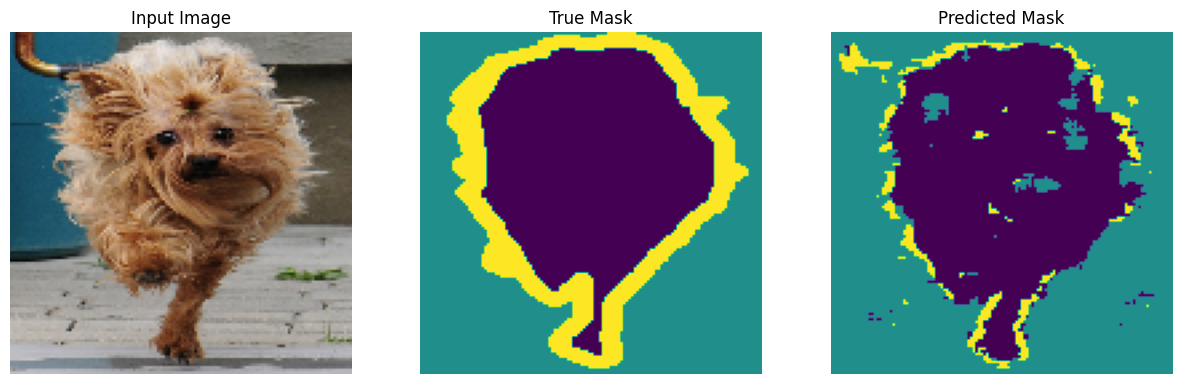


Sample Prediction after epoch 100

57/57 [==============================] - 52s 906ms/step - loss: 0.5903 - accuracy: 0.7518 - val_loss: 0.5948 - val_accuracy: 0.7511


In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = UNET_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(UNET_model.predict(sample_image[tf.newaxis, ...]))])

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


EPOCHS = 100
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
checkpoint_filepath = 'tmp/checkpoint'

#save weights
model_history = UNET_model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback(),tf.keras.callbacks.ModelCheckpoint(
                          filepath=checkpoint_filepath,
                          save_weights_only=True,
                          monitor='val_accuracy',
                          mode='max',
                          save_best_only=True)])

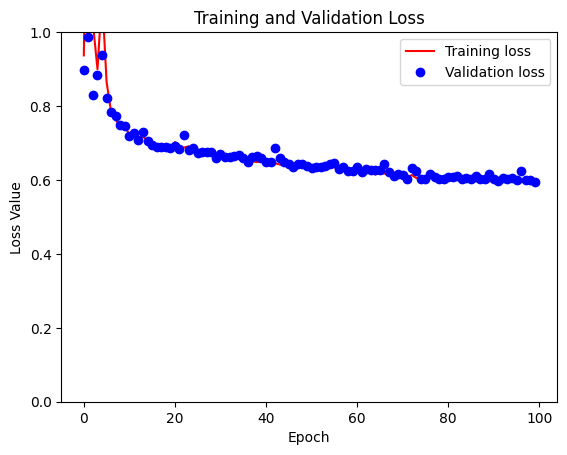

In [ ]:

import matplotlib.pyplot as plt

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

58